# Quantum Simulation of Hamiltonians using Product Formulas

Please execute the cell below before proceeding:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter


## Second-quantized Electronic Structure:

### Dihydrogen Molecule (Molecular Orbital Basis):

#### Via Trotterization Method:

In [3]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()
print(diHydro_prob)


In [4]:
# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
[[-1.25633907e+00 -1.37083854e-17]
 [-6.07732712e-17 -4.71896007e-01]]
 "++--":
[[[[6.75710155e-01 1.69253442e-16]
   [1.56722377e-16 1.80931200e-01]]

  [[4.84650299e-17 1.80931200e-01]
   [6.64581730e-01 3.79897400e-16]]]


 [[[1.01440795e-16 6.64581730e-01]
   [1.80931200e-01 4.71502663e-17]]

  [[1.80931200e-01 3.78920172e-16]
   [6.59828421e-17 6.98573723e-01]]]]


In [5]:
# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op()
print(sq_h2_op)

# This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211568 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211564 * ( +_2 +_1 -_0 -_3 )
+ 0.33229086512764827 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.09046559989211568

In [6]:
# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)
print(qubit_h2_Ham)
#print(qubit_h2_Ham[0])

-0.8105479805373275 * IIII
- 0.22575349222402394 * IIZI
+ 0.17218393261915554 * IIIZ
+ 0.12091263261776629 * IIZZ
+ 0.1721839326191556 * IZII
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605784 * YYYY
+ 0.04523279994605784 * XXYY
+ 0.04523279994605784 * YYXX
+ 0.04523279994605784 * XXXX
- 0.22575349222402388 * ZIII
+ 0.16614543256382414 * ZIIZ
+ 0.16614543256382414 * IZZI
+ 0.17464343068300445 * ZIZI
+ 0.12091263261776629 * ZZII


/home/ssr/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


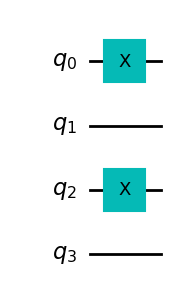

In [12]:
# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

initial_state = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

initial_state.draw('mpl')

In [77]:
# Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

exp_summand = list()
evo_time_range = np.arange(0, 10, 0.1)
evo_time = Parameter('t')

for i in range(0, len(qubit_h2_Ham)):
    exp_summand.append(PauliEvolutionGate(qubit_h2_Ham[i], time=evo_time))


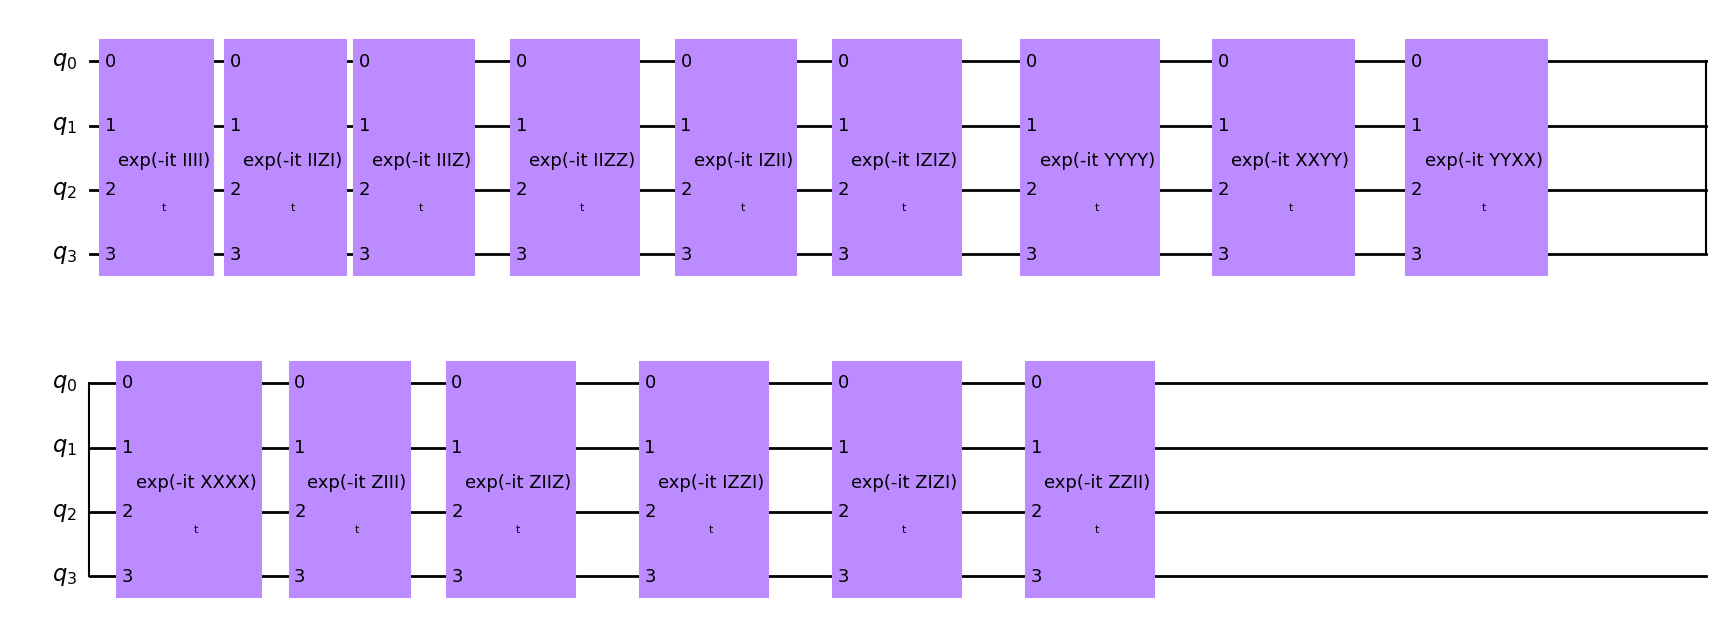

In [78]:
# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

PF_circuit = QuantumCircuit(initial_state.width())

for i in range(len(exp_summand)):
    PF_circuit.append(exp_summand[i], range(initial_state.width()))

PF_circuit.draw('mpl')


In [81]:
# Append PauliEvolutionGates to initial state circuit, initiating a first order trotterization scheme:

repetitions = 10 # Num of repetitions for approximation purposes

composed_circ = initial_state

for i in range(repetitions):
    composed_circ = composed_circ.compose(PF_circuit, range(initial_state.width()))

#composed_circ.draw('mpl')

In [16]:
# Prepare an estimator to measure expectation value of Hamiltonian:

h2_energies = list()
estimator = Estimator()

for k in range(len(evo_time_range)):
    result = estimator.run(composed_circ, qubit_h2_Ham, parameter_values=(evo_time_range[k]/repetitions)).result()
    h2_energies.append(np.real(result.values))

Text(0.5, 1.0, 'Expectation Value of Dihydrogen over Trotterization Evolution')

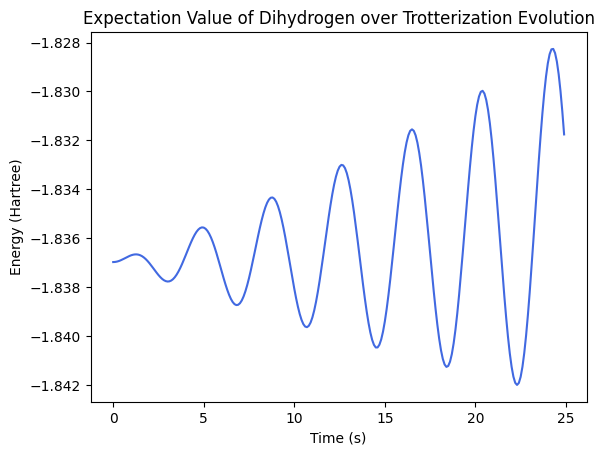

In [17]:
# Graph the energy variation over the specified time interval:

plt.plot(evo_time_range, h2_energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen over Trotterization Evolution")

In [ ]:
# Calculate the expected error:

h2_error = (len(exp_summand)**2 * 0.01**2) / repetitions

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(h2_error) + ")")


20R, 100s: O(112275.11250000002)

In [944]:
# Calculate necessary repetitions to achieve chemical accuracy constant:

rep_need = (len(exp_summand)**2 * evo_time_range[-1]**2) / (1.6*10**(-3))
print(rep_need)

5076.5625


#### Via Standard Tools:

In [75]:
#from qiskit_nature.second_q.circuit.library import BogoliubovTransform
#from qiskit.
standard_evo_time_range_h2 = np.arange(0, 10000, 1)

(array([-1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, 

Text(0.5, 1.0, 'Energy over time')

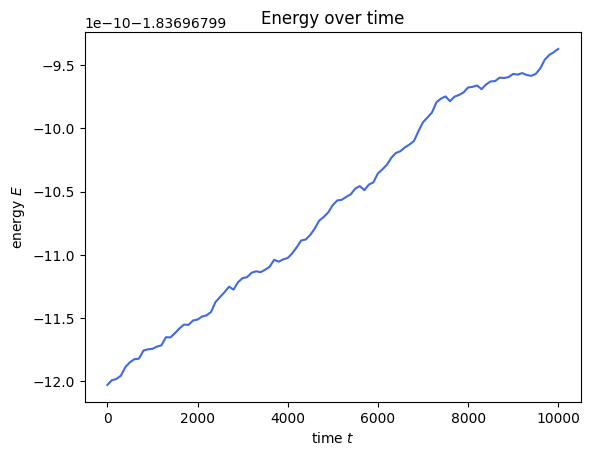

In [76]:
# Invoke the TimeEvolutionProblem to create a problem instance for an evolver:

standard_problem = TimeEvolutionProblem(qubit_h2_Ham, time=standard_evo_time_range_h2[-1], initial_state=initial_state, aux_operators=[qubit_h2_Ham, Pauli("IIII")]) # Create the TimeEvolutionProblem on the Dihydrogen Qubit Hamiltonian.

# Invoke the SciPyRealEvolver to create a TimeEvolutionResult instance:

SciPy = SciPyRealEvolver(100)

# Evolve the Dihydrogen Hamiltonian with respect to the initial Hartree-Fock State:

standard_result = SciPy.evolve(standard_problem)

print(standard_result.observables[0])

# Graph the resulting real time evolution of the system:

energies = np.real(standard_result.observables)[:, 0]

plt.plot(standard_result.times, energies[0], color="royalblue")
plt.xlabel("time $t$")
plt.ylabel("energy $E$")
plt.title("Energy over time")

Lattice-based Hamiltonians:

In [4]:
from math import pi
from qiskit_nature.second_q.hamiltonians.lattices import(
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel, HeisenbergModel, IsingModel
from qiskit_nature.second_q.mappers import LinearMapper
from qiskit.circuit.library import EfficientSU2

Heisenberg Model (Lattice-based):

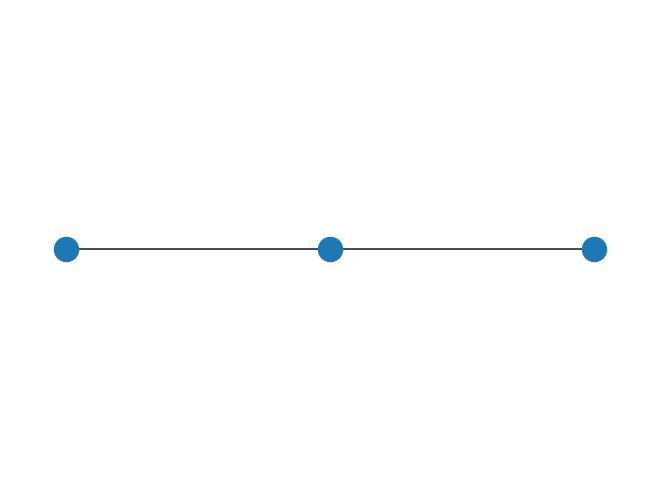

In [17]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
line_lattice.draw()

In [18]:
# Obtain Second Quantized operator of Heisenberg Model Hamiltonian:

hb_Ham = heisenberg_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

lin_map = LinearMapper()

qubit_hb_Ham = lin_map.map(hb_Ham)

#print(qubit_hb_Ham)
#print(qubit_hb_Ham.num_qubits)
#print(hb_Ham)

Spin Operator
spin=1/2, number spins=3, number terms=9
  1.0 * ( X_0 X_1 )
+ 1.0 * ( Y_0 Y_1 )
+ 1.0 * ( Z_0 Z_1 )
+ 1.0 * ( X_1 X_2 )
+ 1.0 * ( Y_1 Y_2 )
+ 1.0 * ( Z_1 Z_2 )
+ 1.0 * ( Z_0 )
+ 1.0 * ( Z_1 )
+ 1.0 * ( Z_2 )


In [866]:
# Construct appropriate ansatz for Variational Time Evolution:

hb_initial_state = QuantumCircuit(qubit_hb_Ham.num_qubits)
hb_initial_state.x(range(0, qubit_hb_Ham.num_qubits, 2))

#hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [894]:
# Generate an appropriate first order trotterization scheme for Heisenberg Model:

hb_exp_summand = list()
hb_evo_time_range = np.arange(0, 1, 0.1)
hb_evo_time = Parameter('t')

for i in range(0, len(qubit_hb_Ham)):
    hb_exp_summand.append(PauliEvolutionGate(qubit_hb_Ham[i], time=evo_time))

#print(len(hb_exp_summand))

In [895]:
# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

hb_PF_circuit = QuantumCircuit(hb_exp_summand[0].num_qubits)

for i in range(len(hb_exp_summand)):
    hb_PF_circuit.append(hb_exp_summand[i], range(hb_exp_summand[i].num_qubits))

#hb_PF_circuit.draw('mpl')

In [896]:
# Append Product Formula to initial state circuit, initiating a first order trotterization scheme:

hb_repetitions = 20 # Num of repetitions for approximation purposes

hb_composed_circ = hb_initial_state

for i in range(hb_repetitions):
    hb_composed_circ = hb_composed_circ.compose(hb_PF_circuit, range(hb_initial_state.width()))

#hb_composed_circ.draw()

In [897]:
# Prepare an estimator to measure expectation value of Hamiltonian:

hb_energies = list()
estimator = Estimator()

for k in range(len(hb_evo_time_range)):
    hb_result = estimator.run(hb_composed_circ, qubit_hb_Ham, parameter_values=(hb_evo_time_range[k]/hb_repetitions)).result()
    hb_energies.append(np.real(hb_result.values))

Text(0.5, 1.0, 'Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution')

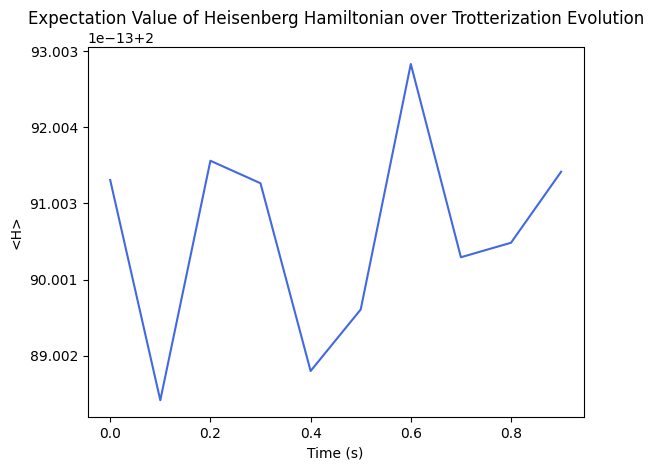

In [898]:
# Graph the energy variation over the specified time interval:

plt.plot(hb_evo_time_range, hb_energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("<H>")
plt.title("Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution")

In [821]:
# Calculate the expected and actual error:

hb_error = (len(hb_exp_summand)**2 * hb_evo_time_range[-1]**2) / hb_repetitions

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(hb_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(117612.0)


Ising Model (Lattice-based):

In [801]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
ising_model = IsingModel(
    line_lattice.uniform_parameters(
        uniform_interaction = -1.0,
        uniform_onsite_potential = 0.0,
    ),
)

In [802]:
# Obtain Second Quantized operator of Ising Model Hamiltonian:

i_Ham = ising_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

lin_map = LinearMapper()

qubit_i_Ham = lin_map.map(i_Ham)

print(qubit_i_Ham)
#print(qubit_hb_Ham.num_qubits)

-0.0625 * IIZIZI
- 0.0625 * IIZIII
+ 0.0625 * IIZIIZ
+ 0.0625 * IIZIII
- 0.0625 * IIIIZI
- 0.0625 * IIIIII
+ 0.0625 * IIIIIZ
+ 0.0625 * IIIIII
+ 0.0625 * IIIZZI
+ 0.0625 * IIIZII
- 0.0625 * IIIZIZ
- 0.0625 * IIIZII
+ 0.0625 * IIIIZI
+ 0.0625 * IIIIII
- 0.0625 * IIIIIZ
- 0.0625 * IIIIII
- 0.0625 * ZIZIII
- 0.0625 * ZIIIII
+ 0.0625 * ZIIZII
+ 0.0625 * ZIIIII
- 0.0625 * IIZIII
- 0.0625 * IIIIII
+ 0.0625 * IIIZII
+ 0.0625 * IIIIII
+ 0.0625 * IZZIII
+ 0.0625 * IZIIII
- 0.0625 * IZIZII
- 0.0625 * IZIIII
+ 0.0625 * IIZIII
+ 0.0625 * IIIIII
- 0.0625 * IIIZII
- 0.0625 * IIIIII


In [803]:
# Construct appropriate ansatz for Real Time Evolution:

i_initial_state = QuantumCircuit(qubit_i_Ham.num_qubits)
i_initial_state.x(range(0, qubit_i_Ham.num_qubits, 2))

#hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [909]:
# Generate an appropriate first order trotterization scheme for Ising Model:

i_exp_summand = list()
i_evo_time_range = np.arange(0, 5, 0.01)
i_evo_time = Parameter('t')

for i in range(0, len(qubit_i_Ham)):
    i_exp_summand.append(PauliEvolutionGate(qubit_i_Ham[i], time=i_evo_time))

In [910]:
# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

i_PF_circuit = QuantumCircuit(i_exp_summand[0].num_qubits)

for i in range(len(i_exp_summand)):
    i_PF_circuit.append(i_exp_summand[i], range(i_exp_summand[i].num_qubits))

#hb_PF_circuit.draw('mpl')

In [911]:
# Append Product Formula to initial state circuit, initiating a first order trotterization scheme:

i_repetitions = 100 # Num of repetitions for approximation purposes

i_composed_circ = i_initial_state

for i in range(i_repetitions):
    i_composed_circ = i_composed_circ.compose(i_PF_circuit, range(i_initial_state.width()))

#hb_composed_circ.draw('mpl')

In [912]:
# Prepare an estimator to measure expectation value of Hamiltonian:

i_energies = list()
estimator = Estimator()

for k in range(len(i_evo_time_range)):
    i_result = estimator.run(i_composed_circ, qubit_i_Ham, parameter_values=(i_evo_time_range[k]/i_repetitions)).result()
    i_energies.append(np.real(i_result.values))

Text(0.5, 1.0, 'Expectation Value of Ising Hamiltonian over Trotterization Evolution')

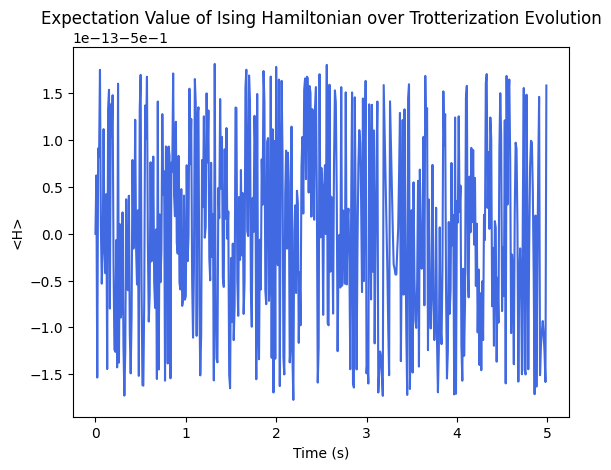

In [918]:
# Graph the energy variation over the specified time interval:

plt.plot(i_evo_time_range, i_energies, color="royalblue")
plt.xlabel("Time (s)")
#plt.xlim(0, 1)
plt.ylabel("<H>")
plt.title("Expectation Value of Ising Hamiltonian over Trotterization Evolution")

In [920]:
# Calculate the expected and actual error:

i_error = (len(i_exp_summand)**2 * i_evo_time_range[-1]**2) / i_repetitions

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(i_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(254.97702400000003)
